In [1]:
# !pip list

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
from tensorflow.keras import layers, models

In [6]:
# pip install tensorflow_datasets

### Visualization Utilities


In [3]:
im_width =75
im_height =75
use_normalized_coordinates =True

In [4]:
def draw_bounding_boxes_on_image_array(image, boxes, color=[], thickness=1, display_str_list=()):
    image_pil = PIL.Image.fromarray(image)
    rgbimg = PIL.Image.new("RGBA", image_pil.size)
    rgbimg.paste(image_pil)
    draw_bounding_boxes_on_image(rgbimg, boxes, color, thickness, display_str_list)
    return np.array(rgbimg)

def draw_bounding_boxes_on_image(image, boxes, color=[], thickness=1, display_str_list=()):
    boxes_shape = boxes.shape
    if not boxes_shape:
        return
    if len(boxes_shape) != 2 or boxes_shape[1] != 4:
        raise ValueError('Input must be of size [N,4]')
    for i in range(boxes_shape[0]):
        draw_bounding_box_on_image(image,
                                   boxes[i,1], boxes[i,0], boxes[i,3], boxes[i,2],
                                   color[i],
                                   thickness,
                                   display_str_list[i])

def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax,
                              color='red', thickness=1,
                              display_str_list=None,
                              use_normalized_coordinates=True):
    draw = PIL.ImageDraw.Draw(image)
    im_width, im_height = image.size
    if use_normalized_coordinates:
        (left, right, top, bottom) = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)
    else:
        (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)],
              width=thickness, fill=color)

In [5]:
def dataset_to_numpy_util(training_dataset, validation_dataset, N):
    batch_train_ds = training_dataset.unbatch().batch(N)
    
    if tf.executing_eagerly():
        for validation_digits, (validation_labels, validation_bboxes) in validation_dataset:
            validation_digits = validation_digits.numpy()
            validation_labels = validation_labels.numpy()
            validation_bboxes = validation_bboxes.numpy()
            break
        for training_digits, (training_labels, training_bboxes) in training_dataset:
            training_digits = training_digits.numpy()
            training_labels = training_labels.numpy()
            training_bboxes = training_bboxes.numpy()
            break

    validation_labels = np.argmax(validation_labels, axis=1)
    training_labels = np.argmax(training_labels, axis=1)
    return (training_digits, training_labels, training_bboxes,
            validation_digits, validation_labels, validation_bboxes)


In [6]:
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

def create_digits_from_local_fonts(n):
    font_labels = []
    img = PIL.Image.new('LA', (75*n, 75), color=(0, 255))
    font1 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'DejaVuSansMono-Oblique.ttf'), 25)
    font2 = PIL.ImageFont.truetype(os.path.join(MATPLOTLIB_FONT_DIR, 'STIXGeneral.ttf'), 25)
    d = PIL.ImageDraw.Draw(img)
    for i in range(n):
        font_labels.append(i % 10)
        d.text(((7 + i * 75, 0 if i < 10 else -4)), str(i % 10), fill=(255, 255), font=font1 if i < 10 else font2)
    font_digits = np.array(img.getdata(), np.float32)[:, 0] / 255.0
    font_digits = np.reshape(np.stack(np.split(np.reshape(font_digits, [75, 75 * n], axis=1), axis=0))[n, 75 * 75])
    return font_digits, font_labels

In [7]:
def display_digits_with_boxes(digits, predictions, labels, pred_bboxes, bboxes, iou, title):
    n = 3
    indexes = np.random.choice(len(predictions), size=n)
    n_digits = digits[indexes]
    n_predictions = predictions[indexes]
    n_labels = labels[indexes]
    n_iou = []
    if len(iou) > 0:
        n_iou = iou[indexes]

    if len(pred_bboxes) > 0:
        n_pred_bboxes = pred_bboxes[indexes]

    if len(bboxes) > 0:
        n_bboxes = bboxes[indexes]

    n_digits = n_digits * 255.0
    n_digits = n_digits.reshape(n, 75, 75)
    fig = plt.figure(figsize=(20, 4))
    plt.title(title)
    plt.xticks([])
    plt.yticks([])

    for i in range(n):
        ax = fig.add_subplot(1, n, i + 1)
        bboxes_to_plot = []
        if (len(pred_bboxes) > i):
            bboxes_to_plot.append(n_pred_bboxes[i])
        if (len(bboxes) > i):
            bboxes_to_plot.append(n_bboxes[i])

        img_to_draw = draw_bounding_boxes_on_image_array(
            image=n_digits[i],
            boxes=np.asarray(bboxes_to_plot),
            color=['red', 'green'],
            display_str_list=["True", "Pred"]
        )

        plt.xlabel(n_predictions[i])
        plt.xticks([])
        plt.yticks([])

        if n_predictions[i] != n_labels[i]:
            ax.xaxis.label.set_color('red')

        plt.imshow(img_to_draw)

        if len(n_iou) > i:
            color = "black"
            if (n_iou[i][0] < iou_threshold):
                color = "red"
            ax.text(0.2, -0.3, "iou: %s" % (n_iou[i][0]), color=color, transform=ax.transAxes)

In [8]:
def plot_metrics(metric_name, title):
    plt.title(title)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    plt.plot(history.history['val_' + metric_name], color='green', label='val_' + metric_name)

### 2. Loading and Preprocessing the dataset

In [9]:
strategy = tf.distribute.get_strategy()
strategy.num_replicas_in_sync

1

In [10]:
BATCH_SIZE = 64 * strategy.num_replicas_in_sync


In [11]:
def read_image_tfds(image, label):
    # Random offsets for padding to 75x75
    xmin = tf.random.uniform(shape=(), minval=0, maxval=48, dtype=tf.int32)
    ymin = tf.random.uniform(shape=(), minval=0, maxval=48, dtype=tf.int32)

    # Reshape MNIST image to (28,28,1)
    image = tf.reshape(image, (28, 28, 1))

    # Pad image with offset to (75, 75)
    image = tf.image.pad_to_bounding_box(image, ymin, xmin, 75, 75)

    # Normalize pixel values to [0,1]
    image = tf.cast(image, tf.float32) / 255.0

    # Convert coordinates to float32
    xmin = tf.cast(xmin, tf.float32)
    ymin = tf.cast(ymin, tf.float32)

    # Compute normalized bounding box coordinates
    xmax = (xmin + 28) / 75.0
    ymax = (ymin + 28) / 75.0
    xmin = xmin / 75.0
    ymin = ymin / 75.0

    # One-hot encode label
    label_one_hot = tf.one_hot(label, 10)

    # Return image and tuple of label and bounding box
    return image, (label_one_hot, tf.stack([xmin, ymin, xmax, ymax]))


In [12]:
def get_training_dataset():
    dataset = tfds.load("mnist", split="train", as_supervised=True, try_gcs=True)
    dataset = dataset.map(read_image_tfds, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(5000).repeat()
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset




In [13]:
def get_validation_dataset():
    dataset = tfds.load("mnist", split="train", as_supervised=True, try_gcs=True)
    dataset = dataset.map(read_image_tfds, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(10000, drop_remainder=True)
    dataset = dataset.repeat()
    return dataset

In [14]:
with strategy.scope():
    training_dataset = get_training_dataset()
    validation_dataset = get_validation_dataset()

In [15]:
(training_digits, training_labels, training_bboxes, 
 validation_digits, validation_labels, validation_bboxes) = dataset_to_numpy_util(training_dataset, validation_dataset, 10)

### 3. Visualize Data

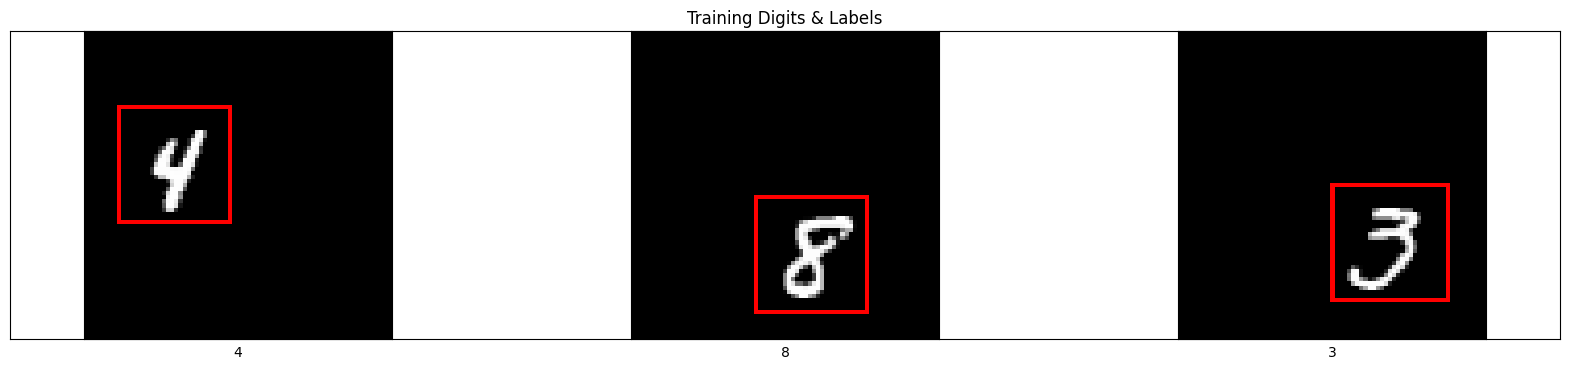

In [16]:
display_digits_with_boxes(
    training_digits, training_labels, training_labels, 
    np.array([]), training_bboxes, np.array([]), 
    "Training Digits & Labels")



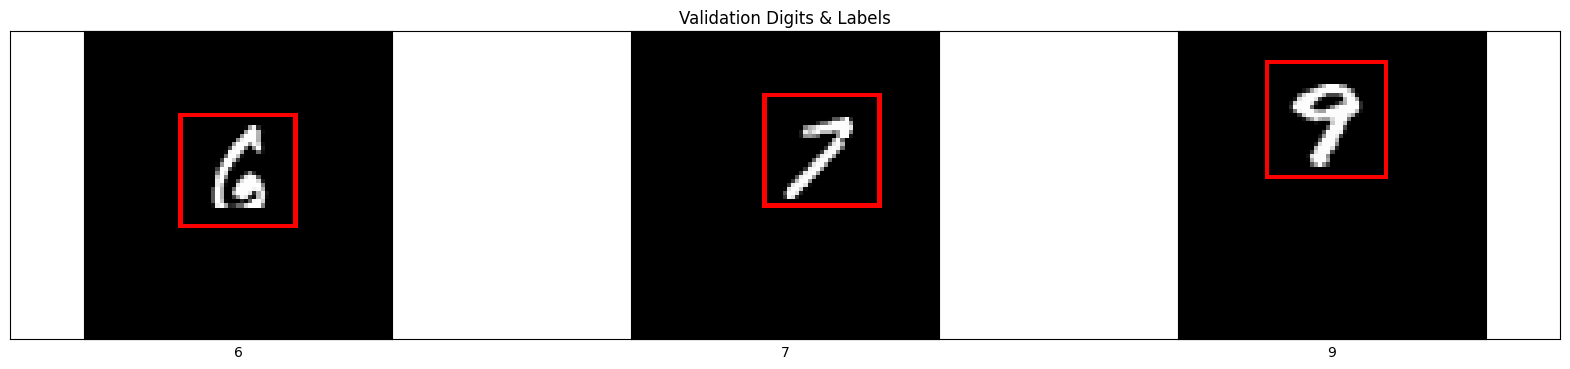

In [17]:
display_digits_with_boxes(
    validation_digits, validation_labels, validation_labels, 
    np.array([]), validation_bboxes, np.array([]), 
    "Validation Digits & Labels")


### 4. Define the Network 

In [18]:
def feature_extractor(inputs):
    x = tf.keras.layers.Conv2D(16, activation='relu', kernel_size=3, input_shape=(75,75,1))(inputs)
    x = tf.keras.layers.AveragePooling2D((2,2))(x)

    x = tf.keras.layers.Conv2D(32, activation='relu', kernel_size=3)(x)
    x = tf.keras.layers.AveragePooling2D((2,2))(x)

    x = tf.keras.layers.Conv2D(64, activation='relu', kernel_size=3)(x)
    x = tf.keras.layers.AveragePooling2D((2,2))(x)

    return x

In [19]:
def dense_layers(inputs):
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    return x

In [20]:
def classifier(inputs):
    classification_output = tf.keras.layers.Dense(10, activation="softmax", name="classification")(inputs)
    return classification_output

In [21]:
def bounding_box_regression(inputs):
    bounding_box_regression_output = tf.keras.layers.Dense(4, name="bounding_box")(inputs)
    return bounding_box_regression_output

In [22]:
def final_model(inputs):
    feature_cnn = feature_extractor(inputs)
    dense_output = dense_layers(feature_cnn)  
    
    classification_output = classifier(dense_output)  
    bounding_box_output = bounding_box_regression(dense_output)

    model = tf.keras.Model(inputs=inputs, outputs=[classification_output, bounding_box_output])
    return model


In [23]:
def define_and_compile_model(inputs):
    model = final_model(inputs)
    model.compile(
        optimizer='adam',
        loss={
            'classification': 'categorical_crossentropy',
            'bounding_box': 'mse'
        },
        metrics={
            'classification': ['accuracy'],
            'bounding_box': ['mse']
        }
    )

    return model   



In [24]:
with strategy.scope():
    inputs = tf.keras.layers.Input(shape=(75, 75, 1))
    model = define_and_compile_model(inputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 75, 75, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 73, 73, 16)           160       ['input_1[0][0]']             
                                                                                                  
 average_pooling2d (Average  (None, 36, 36, 16)           0         ['conv2d[0][0]']              
 Pooling2D)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)           (None, 34, 34, 32)           4640      ['average_pooling2d[0][0]'

### 5. Train and Validate the Model

In [26]:
EPOCHS = 20
steps_per_epoch = 60000 // BATCH_SIZE

history = model.fit(
    training_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_dataset,
    validation_steps=1,
    epochs=EPOCHS
)



Epoch 1/20
937/937 [==============================] - 118s 125ms/step - loss: 0.2374 - classification_loss: 0.2303 - bounding_box_loss: 0.0072 - classification_accuracy: 0.9309 - bounding_box_mse: 0.0072 - val_loss: 0.1880 - val_classification_loss: 0.1833 - val_bounding_box_loss: 0.0047 - val_classification_accuracy: 0.9475 - val_bounding_box_mse: 0.0047
Epoch 2/20
937/937 [==============================] - 98s 105ms/step - loss: 0.1764 - classification_loss: 0.1724 - bounding_box_loss: 0.0040 - classification_accuracy: 0.9483 - bounding_box_mse: 0.0040 - val_loss: 0.1495 - val_classification_loss: 0.1466 - val_bounding_box_loss: 0.0029 - val_classification_accuracy: 0.9570 - val_bounding_box_mse: 0.0029
Epoch 3/20
937/937 [==============================] - 98s 105ms/step - loss: 0.1411 - classification_loss: 0.1383 - bounding_box_loss: 0.0028 - classification_accuracy: 0.9577 - bounding_box_mse: 0.0028 - val_loss: 0.1383 - val_classification_loss: 0.1359 - val_bounding_box_loss: 0.00

KeyboardInterrupt: 

In [31]:
results = model.evaluate(validation_dataset, steps=1)
print("Evaluation Results:", results)
print("Metrics Names:", model.metrics_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - bounding_box_mse: 0.0012 - classification_accuracy: 0.9873 - loss: 0.0415
Evaluation Results: [0.04148370772600174, 0.0011708523379638791, 0.9872999787330627]
Metrics Names: ['loss', 'compile_metrics']


In [1]:
loss, bounding_box_mse, classification_accuracy = model.evaluate(validation_dataset, steps=1)
print("Total Loss:", loss)
print("Bounding Box MSE:", bounding_box_mse)
print("Classification Accuracy:", classification_accuracy)


NameError: name 'model' is not defined

In [41]:
print(model.metrics_names)

['loss', 'compile_metrics']


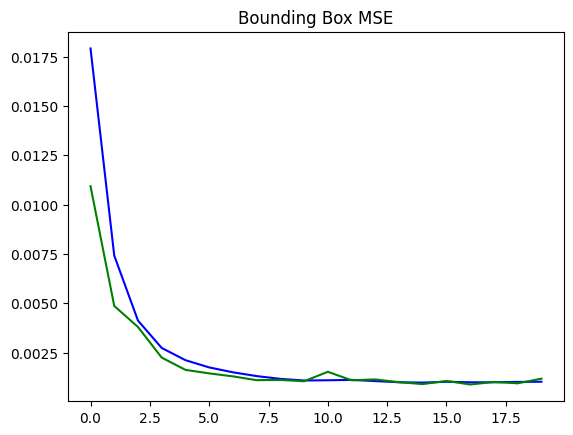

In [33]:
plot_metrics("bounding_box_mse", "Bounding Box MSE")

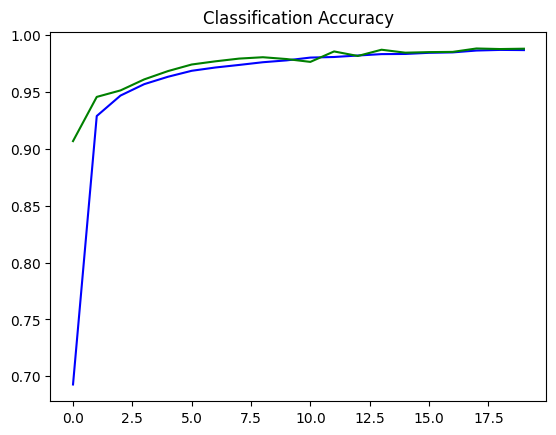

In [34]:
plot_metrics("classification_accuracy", "Classification Accuracy")

In [ ]:
plot_metrics("classification_loss", "Classification loss")

In [46]:
def intersection_over_union(pred_box, true_box):
    xmin_pred, ymin_pred, xmax_pred, ymax_pred = np.split(pred_box, 4, axis=1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis=1)

    smoothing_factor = 1e-10

    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)
    overlap_area = np.maximum((xmax_overlap - xmin_overlap), 0) * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area

    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)
    return iou

In [47]:
prediction = model.predict(validation_digits, batch_size=64)
predicted_labels = np.argmax(prediction[0], axis=1)
prediction_bboxes = prediction[1]

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step


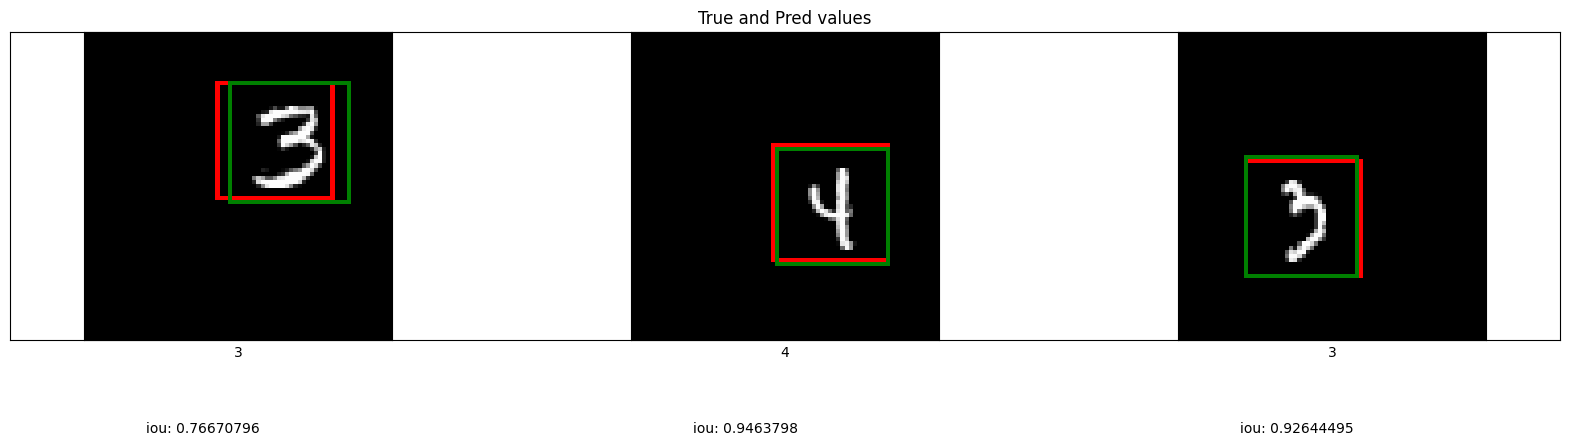

In [48]:
iou = intersection_over_union(prediction_bboxes, validation_bboxes)
iou_threshold = 0.6

display_digits_with_boxes(
    validation_digits, 
    predicted_labels, 
    validation_labels, 
    prediction_bboxes, 
    validation_bboxes, 
    iou, 
    "True and Pred values"
)

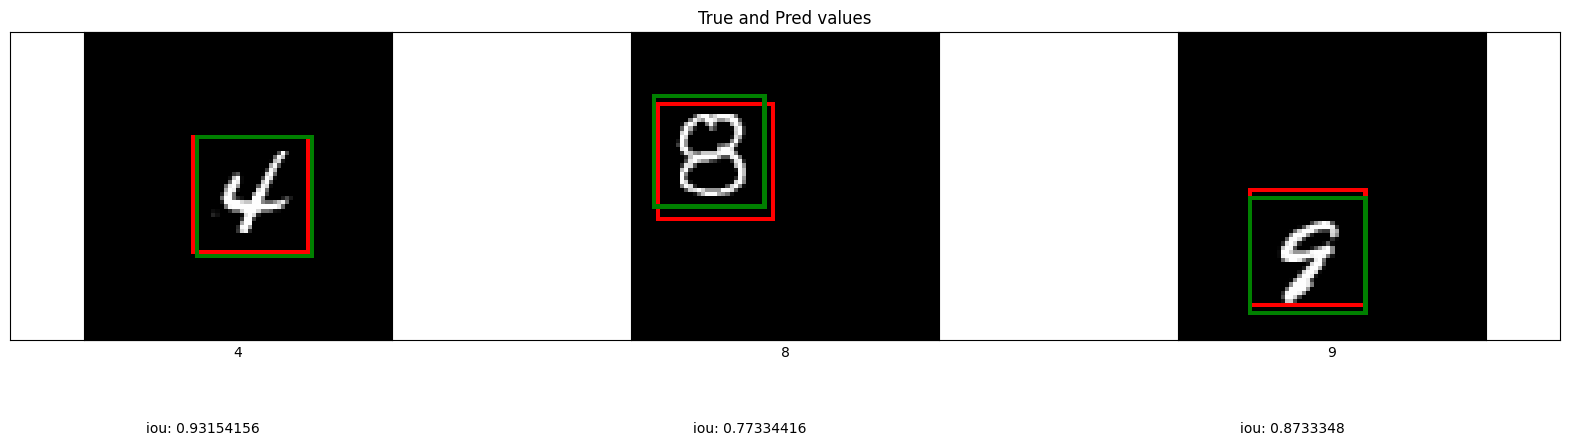

In [49]:
display_digits_with_boxes(
    validation_digits,
    predicted_labels,
    validation_labels,
    prediction_bboxes,
    validation_bboxes,
    iou,
    "True and Pred values"
)

In [ ]:
# loss, classification_loss, bounding_box_loss, classification_acc, bounding_box_mse = model.evaluate(validation_dataset, steps=1)
# print("\n-----------------\n")
# print("Validation Accuracy:", classification_acc)
# print("\n-----------------\n")